<H2>Capstone Final project
<H4>Find the job in Europe - Data Science project

<h3>Introduction 

Nowadays, people are urgent to find suitable jobs in the market. Whether you are choosing to move to another country or stay in hometown, finding a job will be the first thing for a young man or woman make decisions about where to live.

In this section, I will focus on European job market to analyze the opportunities and quality of life, so that individuals and companies can compare with their current location. 

- For individuals, it would be interesting to balance job opportunities with quality of life, giving different weights to each depending on their specific condition. 

- For companies, it would be interesting to compare the job marketing where they are with others and see where they would be more successful at recruiting/retaining talent.

<H3> Source of Data

Data used for analyzing show as following:
- <b> Job opportunity: </b></n>number of Data Scientist job posting in LinkdeIn, for each city in the temperature table, averaged between the two job sites and normalized by the total. Cities with zero job postings will be excluded at this step.
- <b> City type: 
</b></n>collect from Foursquare, search by cities geocodes
- <b> Temperature: 
</b></n>monthly temperature levels of European cities, from wikipedia website:
  https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature#Europe

<h3>Methodoloy

Compare cities using three types of data, which are job, foursquare and temperature. While the distance calculated using weighted Minkowski method, from Scipy's spacial distance module.

All cities use same weight and group by hierarchical cluster - Scipy cluster.

Four types of comparisons performed on 4 possible stakeholders from a base city:
Junior Data Science practitioner : select the 5 best markets, then get the match score based on temperature and venues.
mid-level :  get score with the same weight to the 3 measures.
Senior :  get the score with zero weight on job opportunities.
Company :  get the 5 worst markets and get the match score for temperature and venues on them.

The base city chosen is Shanghai, China

In [1]:
import time
from bs4 import BeautifulSoup
import re
import numpy as np
import folium
from scipy.spatial.distance import pdist, minkowski, squareform
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#Define Foursquare
CLIENT_ID = 'B4MPVM3TW0SVEIYNLFVPXU2LNC5RYTW3BA20MQR0MTROF4UM'
CLIENT_SECRET = 'KR1SJSPQ4YCMYYWAA120IVI3FUSQ20JJM3FED2T2BR1NNPFV'
VERSION = '20180605'

In [3]:
%matplotlib inline

In [4]:
#Data Collection
url = 'https://en.wikipedia.org/w/index.php?title=List_of_cities_by_average_temperature&section=3#Europe'
page = requests.get(url)
soup = BeautifulSoup(page.content,"html.parser")
for caption in soup.find_all('caption'):
    x = caption.get_text()
    if "Europe" in x:
        print('Test is ok')
        table = caption.find_parent('table',{'class':'wikitable plainrowheaders sortable'})

Test is ok


In [5]:
cols = [x.get_text().replace('\n','') for x in table.select('th')]

In [6]:
tb_content = [re.sub("\(.*\)",'',x.get_text().replace('\n','')) for x in table.select('td')]

In [7]:
ttable = pd.DataFrame()
for i in range(15):
    ttable[cols[i]] = [tb_content[x] for x in np.arange(i,len(tb_content),16)]
ttable.head()
ttable

,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
0,Albania,Tirana,6.7,7.8,10.0,13.4,18.0,21.6,24.0,23.8,20.7,16.0,11.7,8.1,15.2
1,Austria,Vienna,0.3,1.5,5.7,10.7,15.7,18.7,20.8,20.2,15.4,10.2,5.1,1.1,10.4
2,Belarus,Minsk,−4.5,−4.4,0.0,7.2,13.3,16.4,18.5,17.5,12.1,6.6,0.6,−3.4,6.7
3,Belgium,Brussels,3.3,3.7,6.8,9.8,13.6,16.2,18.4,18.0,14.9,11.1,6.8,3.9,10.5
4,Bosnia and Herzegovina,Sarajevo,−0.5,1.4,5.7,10.0,14.8,17.7,19.7,19.7,15.3,11.0,5.4,0.9,10.1
5,Bulgaria,Sofia,−0.5,1.1,5.4,10.6,15.4,18.9,21.2,21.0,16.5,11.3,5.1,0.7,10.6
6,Croatia,Zagreb,0.3,2.3,6.4,10.7,15.8,18.8,20.6,20.1,15.9,10.5,5.0,1.4,10.7
7,Cyprus,Nicosia,10.6,10.6,13.1,17.1,22.3,26.9,29.7,29.4,26.2,22.3,16.3,12.0,19.7
8,Czech Republic,Prague,−1.4,−0.4,3.6,8.4,13.4,16.1,18.2,17.8,13.5,8.5,3.1,−0.3,8.4
9,Denmark,Copenhagen,1.4,1.4,3.5,7.7,12.5,15.6,18.1,17.7,13.9,9.8,5.5,2.5,9.1


In [8]:
#get latitude and longitude of cities
region = 'us'
search_url = 'https://{}1.locationiq.com/v1/search.php'.format(region)

ll = []
CLIENT_ID = 'B4MPVM3TW0SVEIYNLFVPXU2LNC5RYTW3BA20MQR0MTROF4UM'
CLIENT_SECRET = 'KR1SJSPQ4YCMYYWAA120IVI3FUSQ20JJM3FED2T2BR1NNPFV'
VERSION = '20180605'
apikey = '5c9b6e38348b1c'

for i in range(len(ttable.City)):
    country = ttable.Country[i]
    city = ttable.City[i]
    data = {'key':apikey,'city':city, 'country':country,'format':'json'}
    LIQresponse = requests.get(search_url, params = data)
    lat = LIQresponse.json()[0]['lat']
    lon = LIQresponse.json()[0]['lon']
    name = LIQresponse.json()[0]['display_name']
    print(name)
    ll.append([country, city, lat, lon, name])
    #add pause to not reach the api limit
    time.sleep(1)

Tirana, Tirana Municipally, Tirana County, Central Albania, 1001-1028, Albania
Vienna, 1010, Austria
Национальный аэропорт "Минск", Kastrychnitski District, Minsk, 220054, Belarus
Brussels, Ville de Bruxelles - Stad Brussel, Brussels-Capital, Belgium
Sarajevo, New Sarajevo municipality, City of Sarajevo, Sarajevo Canton, Federation of Bosnia and Herzegovina, 71000, Bosnia and Herzegovina
Sofia, Sofia City, Sofia-City, Bulgaria
Zagreb, City of Zagreb, Croatia
Nicosia, Cyprus
Prague, okres Hlavní město Praha, Hlavní město Praha, Prague, Czech Republic
Copenhagen, Copenhagen Municipality, Capital Region of Denmark, 1357, Denmark
Tallinn, Kesklinna linnaosa, Tallinn, Harju maakond, Estonia
Helsinki, Helsinki sub-region, Uusimaa, Mainland Finland, Finland
Kuopio, Kuopio sub-region, North Savo, Mainland Finland, Finland
Oulu, Oulun seutukunta, North Ostrobothnia, Mainland Finland, Finland
Marseille, Bouches-du-Rhône, Provence-Alpes-Côte d'Azur, Metropolitan France, 13000, France
Paris, Ile-d

In [9]:
lltable = pd.DataFrame(ll,columns='Country,City,lat,lon,display_name'.split(','))
lltable.head()

,Country,City,lat,lon,display_name
0,Albania,Tirana,41.3268733,19.8187913,"Tirana, Tirana Municipally, Tirana County, Cen..."
1,Austria,Vienna,48.2083537,16.3725042,"Vienna, 1010, Austria"
2,Belarus,Minsk,53.8892876,28.0341956,"Национальный аэропорт ""Минск"", Kastrychnitski ..."
3,Belgium,Brussels,50.8436709,4.36743669338796,"Brussels, Ville de Bruxelles - Stad Brussel, B..."
4,Bosnia and Herzegovina,Sarajevo,43.8519774,18.3866868,"Sarajevo, New Sarajevo municipality, City of S..."


In [10]:
lltable.loc[:,['lat','lon']] = lltable.loc[:,['lat','lon']].astype('float')

In [11]:
temp_ll_table = pd.merge(lltable.drop('display_name',axis=1), ttable)
temp_ll_table.head()

,Country,City,lat,lon,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
0,Albania,Tirana,41.3269,19.8188,6.7,7.8,10.0,13.4,18.0,21.6,24.0,23.8,20.7,16.0,11.7,8.1,15.2
1,Austria,Vienna,48.2084,16.3725,0.3,1.5,5.7,10.7,15.7,18.7,20.8,20.2,15.4,10.2,5.1,1.1,10.4
2,Belarus,Minsk,53.8893,28.0342,−4.5,−4.4,0.0,7.2,13.3,16.4,18.5,17.5,12.1,6.6,0.6,−3.4,6.7
3,Belgium,Brussels,50.8437,4.36744,3.3,3.7,6.8,9.8,13.6,16.2,18.4,18.0,14.9,11.1,6.8,3.9,10.5
4,Bosnia and Herzegovina,Sarajevo,43.852,18.3867,−0.5,1.4,5.7,10.0,14.8,17.7,19.7,19.7,15.3,11.0,5.4,0.9,10.1


In [12]:
temp_ll_table.to_csv('temp_table.csv')

<h3> Data Science jobs per city

In [13]:
temp_ll_table = pd.read_csv('temp_table.csv',index_col=0)

In [14]:
jtable = []
linkedin_baseurl='https://www.linkedin.com/jobs/search/?keywords=data%20scientist&location='
careerjet_baseurl='https://www.careerjet.com.mt/wsearch/jobs?s=data+scientist&l='

for i in range(temp_ll_table.shape[0]):
    city = temp_ll_table.loc[i,'City']
    country = temp_ll_table.loc[i,'Country']
    print(i,'-',city,'-',country,end='\r')
    # get number of linkedin jobs
    lk=[]; attempt = 1 
    while lk == [] and attempt < 5:
        attempt+=1
        lkres = requests.get(linkedin_baseurl+city+'%2C'+country)
        lk = re.findall(r'"total":(.+?),"links"',str(lkres.content))
        if lk == []:
            time.sleep(1)
    # get number of careerjet jobs
    cj=[]; attempt = 1 
    while cj == [] and attempt < 5:
        attempt+=1
        cjres = requests.get(careerjet_baseurl+city+'%2C+'+country)
        cj = re.findall(r'class="display_results display_inline"><nobr>.+of (.+?) jobs</nobr>',str(cjres.content))
        if lk == []:
            time.sleep(1)
    # append to list
    jtable.append([city,country,lk,cj])

In [15]:
jdf = pd.DataFrame(jtable,columns='City,Country,lk,cj'.split(','))

In [16]:
def takedata(x):
    if x == []:
        return 0
    else:
        return int(x[0])
jjdf = jdf.iloc[:,2:].applymap(lambda x: takedata(x))

In [17]:
# data collected Feb-18,2020,7.55AM IST
pd.concat([jdf[['Country','City']],jjdf],axis=1).to_csv('scraped_jobs.csv')

In [18]:
jobs_table = pd.read_csv('scraped_jobs.csv',index_col=0)

In [19]:
# take the average of the two sites and normalize by the total
avg = jobs_table.iloc[:,2:].mean(axis=1)
jobs_table['job_index'] = normd = avg/avg.sum()
jobs_table.sort_values(by='job_index',ascending=False).head()

,Country,City,lk,cj,job_index
61,United Kingdom,London,0,957,0.278198
42,Russia,Moscow,0,347,0.100872
15,France,Paris,0,327,0.095058
16,Germany,Berlin,0,219,0.063663
34,Netherlands,Amsterdam,0,201,0.058430


In [20]:
# remove absolute values and remove cities with zero jobs
jobs_table2 = jobs_table.drop(['lk','cj'],axis=1).loc[jobs_table.job_index>0].reset_index()
jobs_table2.shape

(41, 4)

In [21]:
# merge jobs and temperature table
tllj_table = pd.merge(temp_ll_table,jobs_table2).drop('index',axis=1)
tllj_table.to_csv('tllj_table.csv')
tllj_table.head()

,Country,City,lat,lon,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year,job_index
0,Austria,Vienna,48.208354,16.372504,0.3,1.5,5.7,10.7,15.7,18.7,20.8,20.2,15.4,10.2,5.1,1.1,10.4,0.029360
1,Belarus,Minsk,53.889288,28.034196,−4.5,−4.4,0.0,7.2,13.3,16.4,18.5,17.5,12.1,6.6,0.6,−3.4,6.7,0.003488
2,Belgium,Brussels,50.843671,4.367437,3.3,3.7,6.8,9.8,13.6,16.2,18.4,18.0,14.9,11.1,6.8,3.9,10.5,0.022384
3,Bulgaria,Sofia,42.697863,23.322179,−0.5,1.1,5.4,10.6,15.4,18.9,21.2,21.0,16.5,11.3,5.1,0.7,10.6,0.001453
4,Czech Republic,Prague,50.087465,14.421254,−1.4,−0.4,3.6,8.4,13.4,16.1,18.2,17.8,13.5,8.5,3.1,−0.3,8.4,0.012791


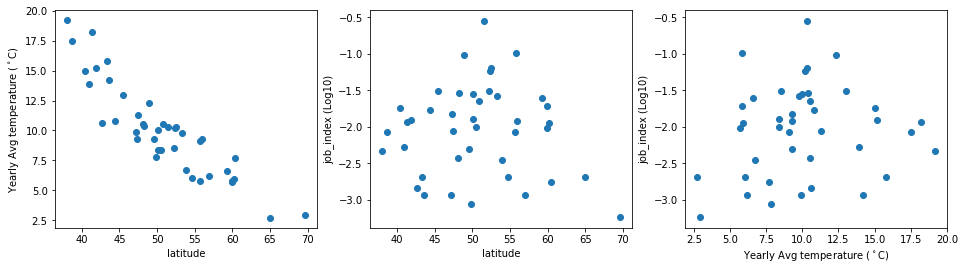

In [22]:
year_tmp = tllj_table['Year']
lat_cities = tllj_table['lat']
jobs_cities_log = np.log10(tllj_table['job_index'].values)

fig, axs = plt.subplots(1, 3, figsize=(16,4))
axs[0].scatter(lat_cities,year_tmp)
axs[0].set_xlabel('latitude')
axs[0].set_ylabel('Yearly Avg temperature ($^\circ$C)')
axs[1].scatter(lat_cities,jobs_cities_log)
axs[1].set_xlabel('latitude')
axs[1].set_ylabel('job_index (Log10)')
axs[2].scatter(year_tmp,jobs_cities_log)
axs[2].set_xlabel('Yearly Avg temperature ($^\circ$C)')
axs[2].set_ylabel('job_index (Log10)')
plt.show()

<h4>Foursquare venues

In [23]:
tllj_table['City,Country,lat,lon'.split(',')].head()

,City,Country,lat,lon
0,Vienna,Austria,48.208354,16.372504
1,Minsk,Belarus,53.889288,28.034196
2,Brussels,Belgium,50.843671,4.367437
3,Sofia,Bulgaria,42.697863,23.322179
4,Prague,Czech Republic,50.087465,14.421254


In [24]:
lng = tllj_table.loc[0,'lon']
radius = 5000 # meters, max = 100,000 ## https://developer.foursquare.com/docs/api/venues/search
LIMIT = 500
INTENT = 'browse'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}'.format(
    CLIENT_ID, CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT,INTENT)

In [25]:
FSres = requests.get(url).json()["response"]['groups'][0]['items']

In [26]:
len([v['venue']['categories'][0]['name'] for v in FSres])

1

In [27]:
tt = pd.DataFrame({'car':'plane,cow,phase,tree,tree,knot'.split(',')})
pd.get_dummies(tt,prefix='',prefix_sep='').mean(axis=0).sum()

1.0

In [28]:
df = tllj_table
venues_list=[]
for city, country,lat,lon in zip(df.City,df.Country,df.lat,df.lon):
    print(city,end='\r')
    # create the API request URL
    radius = 5000 # meters, max = 100,000 ## https://developer.foursquare.com/docs/api/venues/search
    LIMIT = 500
    INTENT = 'browse'
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}\
    &client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}'\
    .format(CLIENT_ID, CLIENT_SECRET,VERSION,lat,lon,radius,LIMIT,INTENT)
    results = requests.get(url).json()["response"]['groups'][0]['items']
    # return only relevant information for each nearby venue
    venues_list.append( [ ( city, country,lat,lng, 
        v['venue']['categories'][0]['name'] ) for v in results ] )

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['City','Country','lat','lon','Venue_Category']

In [29]:
nearby_venues.groupby('City').count()['Venue_Category'].sort_values().head()

City
Minsk         11
Amsterdam    100
Milan        100
Moscow       100
Oslo         100
Name: Venue_Category, dtype: int64

remove city that does not return max. venues

In [30]:
vcount = nearby_venues.groupby('City').count()[['Venue_Category']].rename(columns={'Venue_Category':'Venue_count'})
print(vcount)
selected_cities = vcount.loc[vcount.Venue_count==vcount.Venue_count.max()].index.values.tolist()

                  Venue_count
City                         
Amsterdam                 100
Athens                    100
Barcelona                 100
Bergen                    100
Berlin                    100
Bratislava                100
Brussels                  100
Bucharest                 100
Budapest                  100
Copenhagen                100
Dublin                    100
Edinburgh                 100
Frankfurt                 100
Helsinki                  100
Istanbul                  100
Kiev                      100
Lisbon                    100
London                    100
Luxembourg City           100
Lviv                      100
Madrid                    100
Marseille                 100
Milan                     100
Minsk                      11
Moscow                    100
Oslo                      100
Oulu                      100
Paris                     100
Prague                    100
Riga                      100
Rome                      100
Rostov-on-

In [31]:
bool_cities = [city in selected_cities for city in nearby_venues.City]
nearby_venues_sel = nearby_venues.loc[bool_cities]

In [32]:
nearby_venues_sel.groupby('City').count().min()

Country           100
lat               100
lon               100
Venue_Category    100
dtype: int64

In [33]:
# exported Feb-18,2020,8.00AM IST
nearby_venues_sel.to_csv('nearby_venues_sel.csv',encoding='utf-8-sig')

In [34]:
nearby_venues_sel = pd.read_csv('nearby_venues_sel.csv',index_col=0)
nearby_venues_sel.head()

,City,Country,lat,lon,Venue_Category
0,Vienna,Austria,48.208354,16.372504,Plaza
1,Vienna,Austria,48.208354,16.372504,Church
2,Vienna,Austria,48.208354,16.372504,Restaurant
3,Vienna,Austria,48.208354,16.372504,Cocktail Bar
4,Vienna,Austria,48.208354,16.372504,Gastropub


In [35]:
# test onehot encoding
pd.get_dummies(nearby_venues_sel.iloc[np.r_[0:5, 101:106, 201:206],:]\
               [['City','Venue_Category']].set_index('City'),prefix='',prefix_sep='')\
                .reset_index().groupby('City').mean().reset_index()

,City,Art Museum,Bar,Church,Cocktail Bar,Gaming Cafe,Gastropub,Hotel,Middle Eastern Restaurant,Park,Plaza,Restaurant,Scenic Lookout,Theater
0,Brussels,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.0,0.2,0.0
1,Sofia,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.2
2,Vienna,0.0,0.0,0.2,0.2,0.0,0.2,0.0,0.0,0.0,0.2,0.2,0.0,0.0


In [36]:
# onehot encoding
venues_ot = pd.get_dummies(nearby_venues_sel\
                           [['City','Venue_Category']].set_index('City'),prefix='',prefix_sep='')\
                            .reset_index().groupby('City').mean().reset_index()
venues_ot_backup = venues_ot.copy()
venues_ot = venues_ot.iloc[:,0:301]
print(venues_ot.shape[0],'Cities')
print(venues_ot.shape[1]-1,'Venue categories')
venues_ot.shape[1]

40 Cities
300 Venue categories


301

In [37]:
# see the frenquency of common venues
com = [0]+[list(venues_ot.columns).index(x) for x in ['Café','Church','Restaurant']]
venues_ot.iloc[:10,com]

,City,Café,Church,Restaurant
0,Amsterdam,0.03,0.00,0.04
1,Athens,0.07,0.00,0.00
2,Barcelona,0.01,0.00,0.00
3,Bergen,0.06,0.00,0.03
4,Berlin,0.01,0.00,0.00
5,Bratislava,0.13,0.00,0.01
6,Brussels,0.03,0.00,0.00
7,Bucharest,0.02,0.01,0.03
8,Budapest,0.01,0.01,0.02
9,Copenhagen,0.06,0.00,0.01


<h3> Assemble the data

In [38]:
tllj_table = pd.read_csv('tllj_table.csv',index_col=0)
tllj_table.head()

,Country,City,lat,lon,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year,job_index
0,Austria,Vienna,48.208354,16.372504,0.3,1.5,5.7,10.7,15.7,18.7,20.8,20.2,15.4,10.2,5.1,1.1,10.4,0.029360
1,Belarus,Minsk,53.889288,28.034196,−4.5,−4.4,0.0,7.2,13.3,16.4,18.5,17.5,12.1,6.6,0.6,−3.4,6.7,0.003488
2,Belgium,Brussels,50.843671,4.367437,3.3,3.7,6.8,9.8,13.6,16.2,18.4,18.0,14.9,11.1,6.8,3.9,10.5,0.022384
3,Bulgaria,Sofia,42.697863,23.322179,−0.5,1.1,5.4,10.6,15.4,18.9,21.2,21.0,16.5,11.3,5.1,0.7,10.6,0.001453
4,Czech Republic,Prague,50.087465,14.421254,−1.4,−0.4,3.6,8.4,13.4,16.1,18.2,17.8,13.5,8.5,3.1,−0.3,8.4,0.012791


In [39]:
tllj_sel = tllj_table.iloc[[list(tllj_table.City).index(x) for x in venues_ot.City],:].reset_index(drop='index')

# final table with all the data = Country, City, lat, lon, temperature, jobs, Foursquare_venue_category
assembled_data = pd.concat([tllj_sel,venues_ot.iloc[:,1:]],axis=1)
assembled_data.to_csv('assembled_data.csv')
assembled_data.iloc[:4,:4]

,Country,City,lat,lon
0,Netherlands,Amsterdam,52.374540,4.897976
1,Greece,Athens,37.984149,23.727984
2,Spain,Barcelona,41.382894,2.177432
3,Norway,Bergen,60.394306,5.325919


<h3><b>Analysis

<h4>Data preparation

In [40]:
# read data and keep relevant columns
assembled_data = pd.read_csv('assembled_data.csv',index_col=0)
# city, temp, jobs, foursquare
ctjf_data = assembled_data.loc[:,~assembled_data.columns.isin('Country,lat,lon,Year'.split(','))]
ctjf_data.head()
print(ctjf_data.shape)
ctjf_data.iloc[:5,:16]

(40, 314)


,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,job_index,Adult Boutique,African Restaurant
0,Amsterdam,3.4,3.5,6.1,9.1,12.9,15.4,17.6,17.5,14.7,11.0,7.1,4.0,0.058430,0.0,0.0
1,Athens,10.2,10.9,13.2,16.9,21.8,26.6,29.3,29.3,25.0,20.1,15.5,11.5,0.004651,0.0,0.0
2,Barcelona,11.8,12.4,14.2,15.8,19.3,23.0,25.7,26.1,23.0,19.5,14.9,12.3,0.011628,0.0,0.0
3,Bergen,1.5,1.6,3.3,5.9,10.5,13.5,14.5,14.4,11.5,8.7,4.7,2.6,0.001744,0.0,0.0
4,Berlin,0.6,2.3,5.1,10.2,14.8,17.9,20.3,19.7,15.3,10.5,6.0,1.3,0.063663,0.0,0.0


Make a presentation table, with Year average temperature, jobs in % of total and five most common venues

In [41]:
pres_table = assembled_data[['Country','City','Year']].copy()
pres_table['Jobs (%)'] = assembled_data.job_index.apply(lambda x: x*100).round(2)
pres_table.rename(columns={'Year':'Year Temp'},inplace=True)
print(pres_table)
mc_venues = pd.DataFrame([[cc]+list(ctjf_data.loc[ctjf_data.City==cc].iloc[:,np.r_[0,14:301]].set_index('City')\
    .T.sort_values(by=cc,ascending=False).iloc[:5,:].index.values) for cc in pres_table.City],\
    columns='City, Most common venue, 2nd most common, 3rd most common, 4th most common, 5th most common'\
    .split(', '))
pres_tablef = pd.merge(pres_table,mc_venues)
pres_tablef.shape

           Country              City  Year Temp  Jobs (%)
0      Netherlands         Amsterdam       10.2      5.84
1           Greece            Athens       19.2      0.47
2            Spain         Barcelona       18.2      1.16
3           Norway            Bergen        7.7      0.17
4          Germany            Berlin       10.3      6.37
5         Slovakia        Bratislava       10.5      0.38
6          Belgium          Brussels       10.5      2.24
7          Romania         Bucharest       10.8      1.69
8          Hungary          Budapest       11.3      0.87
9          Denmark        Copenhagen        9.1      0.84
10         Ireland            Dublin        9.8      2.67
11  United Kingdom         Edinburgh        9.3      1.19
12         Germany         Frankfurt       10.0      2.76
13         Finland          Helsinki        5.9      1.13
14          Turkey          Istanbul       13.9      0.52
15         Ukraine              Kiev        8.4      0.99
16        Port

(40, 9)

<h4><b>Similarity score

To correct for the different number of features I will use the weighted Minkowski distance.

First, I will compare all cities between themselves using the same weight for each type of data, and perform hierarchical cluster to group them.

Then, I will perform 4 types of comparisons, based on 4 possible stakeholders:
- Junior Data Science practitioner :select the 5 best markets, then get the match score based on temperature and venues </n>
- mid-level : get score with the same weight to the 3 measures</n>
- Senior : get the score with zero weight on job opportunities</n>
- Company : get the 5 worst markets and get the match score for temperature and venues on them</n>

Before I can work with the distances I have to normalize the job index because the data is skewed. London and Paris together have almost 45% of the total jobs, for instance. The job_index will be logged for the clustering but will be used as percentage in the discussion, for clarity.

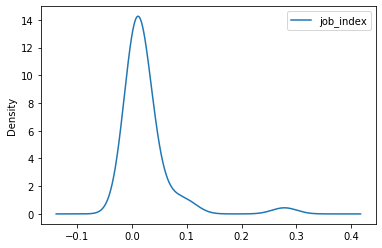

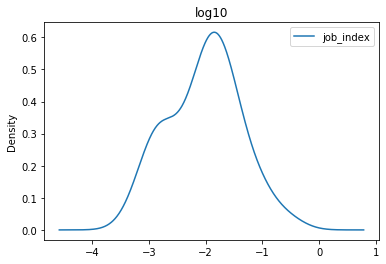

In [42]:
ctjf_data[['job_index']].plot.density()
np.log10(ctjf_data[['job_index']]).plot.density()
plt.title('log10')
plt.show()

In [43]:
# log10 the job_index
ctjf_data2 = ctjf_data.copy()
ctjf_data2['job_index'] = np.log10(ctjf_data2.job_index)
ctjf_data2.shape

(40, 314)

In [44]:
from scipy.spatial.distance import pdist, minkowski, squareform
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [56]:
# Function to get the dissimilarity matrix for the temp-job-foursquare data
def ctjf_wmink(df,tw,jw,fw):
    ## temp_weight,job_weight,foursquare_weight
    # data scaling
    x = df.iloc[:,1:].values
    X = MinMaxScaler().fit(x).transform(x)
    X = StandardScaler().fit(x).transform(x)

    # weights
    l1,l2,l3 = 12,1,300 #of features for each class of data
    wl = np.array([[tw,jw,fw],[l1,l2,l3]])
    ws=[] #weights
    for i in range(3):
        ws+=[wl[0,i]/wl[1,i]]*wl[1,i]
    # Weighted Minkowski
    dx = pdist(X,minkowski,w=ws)
    # square the condensed matrix
    cdx = squareform(dx)
    return(cdx)

<h3>Cluster European Cities

First, cluster all the cities in data with the same weight on each variable, to get a baseline for further comparisons

<h4>Hierachical Clustering

In [58]:
cdx = ctjf_wmink(ctjf_data2,tw=1,jw=1,fw=1)
ctjf_dendro(cdx,'')
labels = ttable.City.values
df = assembled_data

labels = ['{}, {}, {:.2f}, {}'.\
          format(df.Country[i],df.City[i],df.job_index[i]*100,df.Year[i]) for i in range(len(df.City.values))]
# hierarchical cluster
ccdx = hierarchy.complete(squareform(cdx)) # squareform is its own inverse, condenses and expands depending on the shape
plt.figure(figsize=(10,12))
R = hierarchy.dendrogram(ccdx,labels=labels,orientation='right',leaf_font_size=10)

mask = np.ones(cdx.shape, dtype=bool)
np.fill_diagonal(mask, 0)
plt.xlim(cdx[mask].min()*.95,cdx[mask].max()*1.05)
plt.title('European City clusters',fontdict={'fontsize': 15,'fontweight':'bold','verticalalignment':'baseline'},pad=20 )
plt.annotate('Country, City, jobs(%), Year temp',xy=(0.01,0.935),xycoords='figure fraction',\
             fontweight='bold')
plt.show()

ValueError: could not convert string to float: '−0.4'

<h4>Table

In [ ]:
# choosing the cluster that has Lisbon
c0_pres_table = pres_tablef.copy()
# define clusters - using default dendrogram cut method for the colors, from Matlab >> 0.7*max(Z[:,2])
# https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html
c0_pres_table['Cluster'] = hierarchy.fcluster(ccdx,0.7*max(ccdx[:,2]),'distance') 
chosen_cluster = c0_pres_table.loc[c0_pres_table.City=='Lisbon','Cluster'].values[0]
c0_pres_table.loc[c0_pres_table.Cluster==chosen_cluster].sort_values(by=['Cluster','Jobs (%)'],ascending=False)

<h4>Map the clusters

In [ ]:
# Plotting the clusters on a map
df = assembled_data
# European map
lat = 55
lon = 12.102151
Fmap = folium.Map(location=[float(lat), float(lon)], zoom_start=3 , control_scale = True)

# Plot just the cities ---------------------------------------------------------------------------------
# df = assembled_data
# # add markers to map
# for lat, lng, city, country in zip(df['lat'], df['lon'], df['City'], df['Country']):
#     label = '{}, {}'.format(city, country)
#     label = folium.Popup(label, parse_html=True)
#     folium.CircleMarker(  # Circle makes a difined size circle, CircleMarker makes a circle of the same size in all zooms
#         [lat, lng],
#         radius=5,
#         popup=label,
#         color='blue',
#         fill=True,
#         fill_color='#3186cc',
#         fill_opacity=0.7,
#         parse_html=False).add_to(Fmap)  
# Fmap

# Plot cities and clusters  ---------------------------------------------------------------------------------

# set color scheme for the clusters
# k = len(c0_pres_table['Cluster'].unique())
# cmap = cm.get_cmap('Set1', k+1)
# rainbow = [colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)][:-1]
## http://colorbrewer2.org/#type=qualitative&scheme=Set1&n=5
rainbow = '#e41a1c,#377eb8,#4daf4a,#ff7f00'.split(',')

# add markers to map
for lat, lng, cluster, city, country in zip(df['lat'], df['lon'], 
                                            c0_pres_table['Cluster'], df['City'], df['Country']):
     label = 'Cluster: {}, {}, {}'.format(cluster, city, country)
     label = folium.Popup(label, parse_html=True)
     folium.CircleMarker(  
        [lat, lng], radius=6, popup=label, color=rainbow[cluster-1],
        fill=True, fill_color=rainbow[cluster-1], fill_opacity=1, parse_html=False).add_to(Fmap)  
Fmap

<h3><b>For Junior Data Scientists

In [ ]:
# Top 5 markets
sel_t5j = list(pres_tablef.sort_values(by='Jobs (%)',ascending=False).head(5).City.values)
# I'm selecting Lisbon as the comparison city
base_city = ['Lisbon']
sel_c1 = base_city + sel_t5j
sel_c1_ind = [pd.Index(pres_tablef.City).get_loc(x) for x in sel_c1]
c1_pres_table = pres_tablef.iloc[sel_c1_ind,:].copy()
# now I can get the similarity matrix using zero weight for jobs to compare temperature and venues 
dx_junior = ctjf_wmink(ctjf_data2,tw=1,jw=0,fw=1)
dx_junior_df = pd.DataFrame(dx_junior,index=ctjf_data2.City.values,columns=ctjf_data2.City.values)
c1_pres_table['Match'] = dx_junior_df.loc[sel_c1,base_city].apply(lambda x: 100*(1-x)).round(2).values
c1_pres_table = c1_pres_table.sort_values(by='Match',ascending=False)
c1_pres_table

<h4><b>For Mid-level Data Scientists

Top 5 cities to move to based on score, with same weight to the measures

In [ ]:
# dissimilarity matrix
dx_mid = ctjf_wmink(ctjf_data2,tw=1,jw=1,fw=1)
# convert to df
dx_mid_df = pd.DataFrame(dx_mid,index=ctjf_data2.City.values,columns=ctjf_data2.City.values)
# select the best 5 matches to base_city
c2_matches = dx_mid_df[base_city].sort_values(by=base_city).head(6)
sel_c2 = list(c2_matches.index.values)
# index in pres_tablef
sel_c2_ind = [pd.Index(pres_tablef.City).get_loc(x) for x in sel_c2]
c2_pres_table = pres_tablef.iloc[sel_c2_ind,:].copy()
c2_pres_table['Match'] = c2_matches.apply(lambda x: 100*(1-x)).round(2).values
# result
c2_pres_table

<h4><b>For Senior Data Scientists

get score with zero weight on 

In [ ]:
# dissimilarity matrix
dx_mid = ctjf_wmink(ctjf_data2,tw=1,jw=0,fw=1)
# convert to df
dx_mid_df = pd.DataFrame(dx_mid,index=ctjf_data2.City.values,columns=ctjf_data2.City.values)
# select the best 5 matches to base_city
c3_matches = dx_mid_df[base_city].sort_values(by=base_city).head(6)
sel_c3 = list(c3_matches.index.values)
# index in pres_tablef
sel_c3_ind = [pd.Index(pres_tablef.City).get_loc(x) for x in sel_c3]
c3_pres_table = pres_tablef.iloc[sel_c3_ind,:].copy()
c3_pres_table['Match'] = c3_matches.apply(lambda x: 100*(1-x)).round(2).values
# result
c3_pres_table

<h4>For Companies

get the 5 worst markets and get match score for temperature and venues on them

In [ ]:
# Bottom 5 markets
sel_b5j = list(pres_tablef.sort_values(by='Jobs (%)',ascending=True).head(5).City.values)
# I'm selecting Lisbon as the comparison city
base_city = ['Lisbon']
sel_c4 = base_city + sel_b5j
sel_c4_ind = [pd.Index(pres_tablef.City).get_loc(x) for x in sel_c4]
c4_pres_table = pres_tablef.iloc[sel_c4_ind,:].copy()
# now I can get the similarity matrix using zero weight for jobs to compare temperature and venues 
dx_junior = ctjf_wmink(ctjf_data2,tw=1,jw=0,fw=1)
dx_junior_df = pd.DataFrame(dx_junior,index=ctjf_data2.City.values,columns=ctjf_data2.City.values)
c4_pres_table['Match'] = dx_junior_df.loc[sel_c4,base_city].apply(lambda x: 100*(1-x)).round(2).values
c4_pres_table = c4_pres_table.sort_values(by='Match',ascending=False)
c4_pres_table

<h3>Discussion

Cities have varied characteristics and thus comparing them based on 3 criteria can only be described as simplistic. However, this approach looks being useful enough to capture the essence of the problem and provide solutions that seems both viable and interesting.

For different experience profiles the choices are different and thus the projected cities are different as well.

For junior Data Scientists, the assumptions were that 1) they give the highest importance to the number of job opportunities, 2) they want to move to a place similar to where they currently live. Based on these assumptions, the comparison of temperature and Foursquare venues gives Paris, Amsterdam and London as best options.

For mid-level practitioners, the assumption was that they would give the same level of importance to the 3 criteria, assuming they could easily find jobs on similar job markets. Bases on this, Barcelona, Rome and Madrid appeared as the best options.

For senior Data Scientists, that could easily find jobs anywhere these days (even remotely), the assumption was that, if they want to move to a similar city, only the temperature and Foursquare data would be considered. However the best option in this comparison, Barcelona, has also a similar number of job opportunities as Lisbon, and would seem like a good choice. Seville and Marseille come in second and third in the comparison, respectively.

Other criteria can be included in the future to further improve these comparisons, such as rainfall, cost of living (rent, food prices, transportation), housing availability, criminality, and types of Data Science jobs (entry, mid or senior level).

<h3><b>Conclusion

<b>Where should data Scientists move to?

- junior: Paris, Amsterdam or London
- Mid-level: Barcelona, Roma or Madrid
- Senior: Barcelona, Seville or Marseille